In [479]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf) 

In [480]:
def arrival_time(lambda_):
    return np.random.exponential(1 / lambda_)

In [481]:
def time_of_stay(mu):
    return np.random.exponential(mu)

In [482]:
def simulate_arrival_time_day(lambda_, days_simulation):

    total = 0
    arrivals_time = []

    while total < days_simulation:
        time_arrival = arrival_time(lambda_)
        arrivals_time.append(time_arrival)

        total += time_arrival

    return np.array(np.cumsum(arrivals_time))

In [483]:
def extract_new_ward(patient, transition_probability):

    possible_wards = np.arange(0, transition_probability.shape[0])
    new_ward = np.random.choice(possible_wards, p=transition_probability[patient, : ])

    return new_ward

In [484]:
def list_arrive_patient(arrivals_time):
    result = []
    for idx, sublist in enumerate(arrivals_time):
        for value in sublist:
            result.append((value, idx))
    
    # Sort by arrival time (first element of tuple)
    result.sort()
    return result

In [485]:
def count_new_departures(leaving_time, processed, current_time, n_types):
    departures_count = [0] * n_types

    for i, (t, p_type) in enumerate(leaving_time):
        if not processed[i] and t < current_time:
            departures_count[p_type] += 1
            processed[i] = True  # mark as processed

    return departures_count, processed

In [486]:
def simulate(
    transition_probability,
    lambdas,
    mean_length_stay,
    bed_capacity,
    days_simulation
):
    n_types = len(lambdas)
    type_patients = np.arange(n_types)

    occupied_bed = np.zeros(n_types, dtype=int)
    rejected_patients = np.zeros(n_types, dtype=int)

    # Time-tracking
    occupied_bed_timeline = []
    rejected_patients_timeline = []
    time_timeline = []

    # Relocation tracking: [original_type, relocated_to]
    relocated_patients = np.zeros((n_types, n_types), dtype=int)

    # Simulate arrivals per type
    arrival_time_total = [
        simulate_arrival_time_day(lambdas[tp], days_simulation)
        for tp in type_patients
    ]
    mix_arrivals_time = list_arrive_patient(arrival_time_total)
    # Leave tracking
    leaving_time = []
    processed = []

    for arrival_time, patient_type in mix_arrivals_time:
        # Discharge patients whose time has come
        departures_count, processed = count_new_departures(
            leaving_time, processed, arrival_time, n_types
        )
        occupied_bed -= departures_count

        # Try to admit to primary ward
        if occupied_bed[patient_type] < bed_capacity[patient_type]:
            occupied_bed[patient_type] += 1
            stay_time = time_of_stay(mean_length_stay[patient_type])
            departure_time = arrival_time + stay_time
            leaving_time.append((departure_time, patient_type))
            processed.append(False)
        else:
            # Try redirecting
            new_ward = extract_new_ward(patient_type, transition_probability)

            if occupied_bed[new_ward] < bed_capacity[new_ward]:
                occupied_bed[new_ward] += 1
                stay_time = time_of_stay(1 / mean_length_stay[new_ward])
                departure_time = arrival_time + stay_time
                leaving_time.append((departure_time, new_ward))
                processed.append(False)

                # Track relocation from original type to new ward
                relocated_patients[patient_type, new_ward] += 1
            else:
                rejected_patients[patient_type] += 1

        # Record snapshot
        occupied_bed_timeline.append(occupied_bed.copy())
        rejected_patients_timeline.append(rejected_patients.copy())
        time_timeline.append(arrival_time)

    return (
        np.array(occupied_bed_timeline),
        np.array(rejected_patients_timeline),
        np.array(time_timeline),
        leaving_time,
        relocated_patients,
        mix_arrivals_time
    )


In [487]:

P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80],  # From A
    [0.20, 0.00, 0.50, 0.15, 0.15],  # From B
    [0.30, 0.20, 0.00, 0.20, 0.30],  # From C
    [0.35, 0.30, 0.05, 0.00, 0.30],  # From D
    [0.20, 0.10, 0.60, 0.10, 0.00],  # From E
])

bed_capacities = [55, 40, 30, 20, 20]

lambdas = [14.5, 11.0, 8.0, 6.5, 5.0]

mean_length_of_stay = np.array([2.9, 4.0, 4.5, 1.4, 3.9])

days_simulation = 1000

In [488]:
occ_bed_hist, rej_hist, time_hist, leaves, reloc_matrix, mix_time_arrival = simulate(P, lambdas, mean_length_of_stay, bed_capacities, days_simulation)

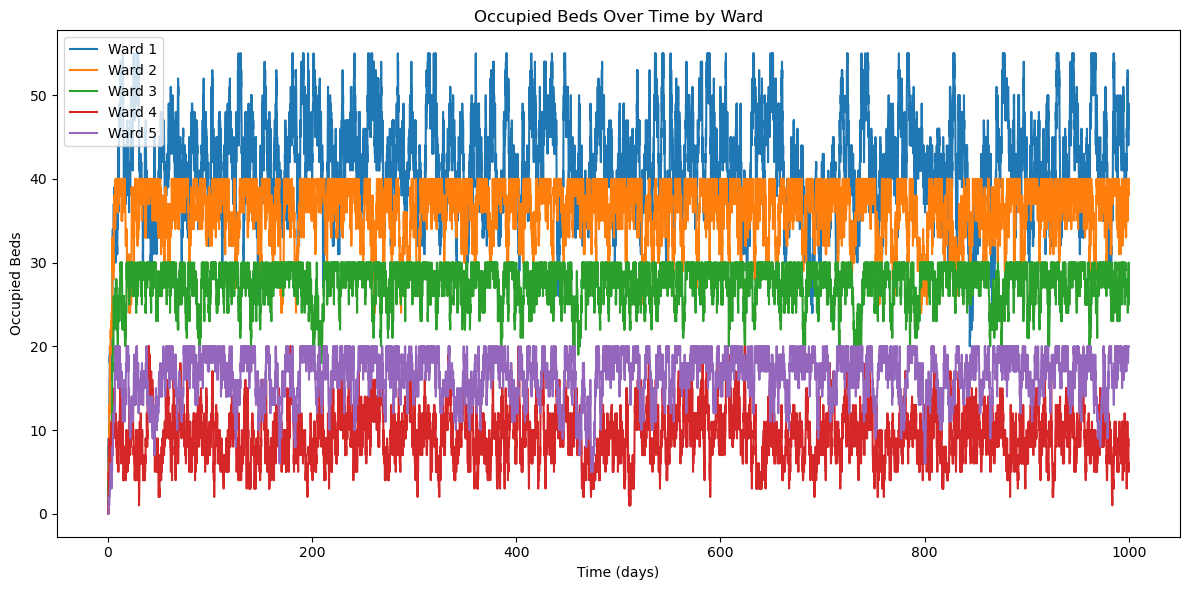

In [489]:
plt.figure(figsize=(12, 6))
for i in range(occ_bed_hist.shape[1]):
    plt.plot(time_hist, occ_bed_hist[:, i], label=f"Ward {i+1}")
plt.xlabel("Time (days)")
plt.ylabel("Occupied Beds")
plt.title("Occupied Beds Over Time by Ward")
plt.legend()
plt.tight_layout()
plt.show()

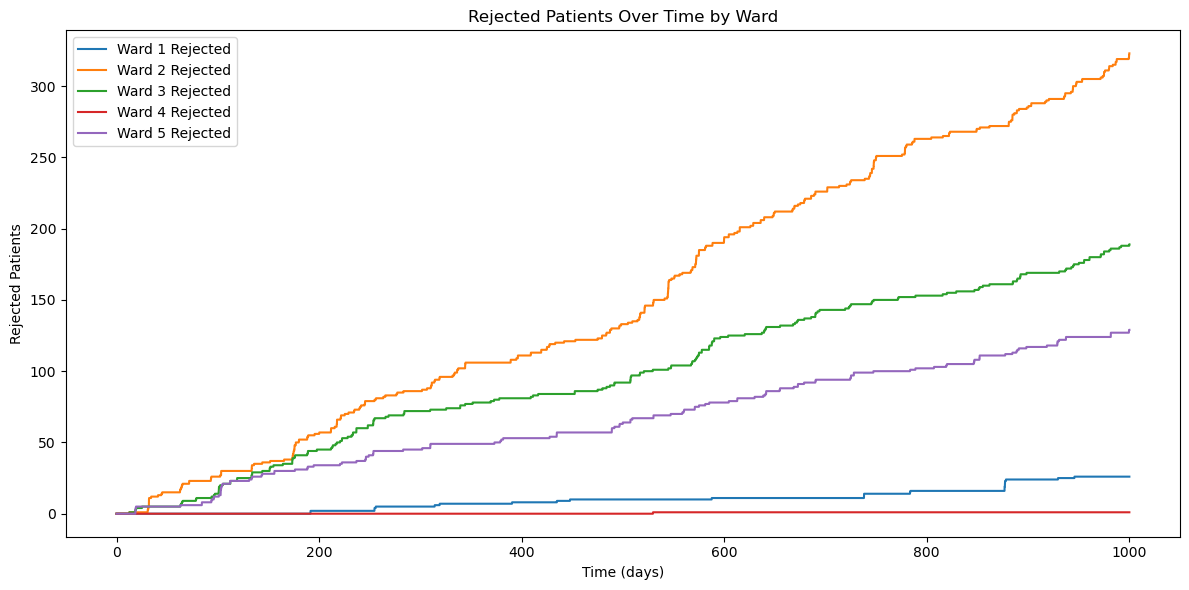

In [490]:
plt.figure(figsize=(12, 6))
for i in range(rej_hist.shape[1]):
    plt.plot(time_hist, rej_hist[:, i], label=f"Ward {i+1} Rejected")
plt.xlabel("Time (days)")
plt.ylabel("Rejected Patients")
plt.title("Rejected Patients Over Time by Ward")
plt.legend()
plt.tight_layout()
plt.show()

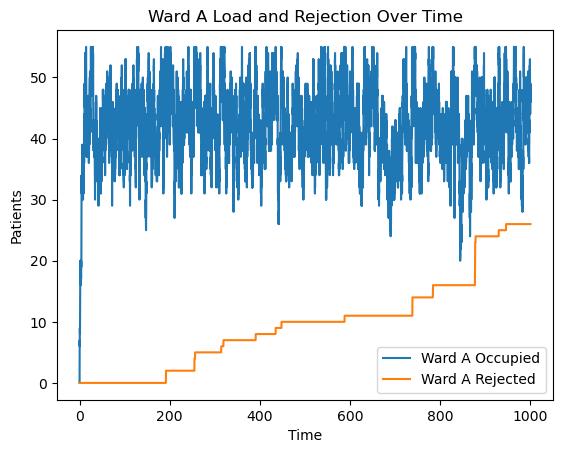

In [491]:
plt.plot(time_hist, occ_bed_hist[:, 0], label='Ward A Occupied')
plt.plot(time_hist, rej_hist[:, 0], label='Ward A Rejected')
plt.xlabel("Time")
plt.ylabel("Patients")
plt.legend()
plt.title("Ward A Load and Rejection Over Time")
plt.show()


In [492]:
print(reloc_matrix)

[[  0   5   6   6  92]
 [361   0 591 274 235]
 [568 293   0 364 480]
 [  3   0   0   0   1]
 [139  73 313  75   0]]
